In [79]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from tensorflow.keras.layers import BatchNormalization
from keras.utils.np_utils import to_categorical 

from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [35]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))

    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')

    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [5]:
base_skin_dir = os.path.join(r'C:\Users\MDP\Documents\Proje_B\Inputs')


imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}


lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [6]:
skin_df = pd.read_csv(os.path.join(r'C:\Users\MDP\Documents\Proje_B\Inputs\HAM10000_metadata.csv'))


skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [40]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,C:\Users\MDP\Documents\Proje B\Inputs\HAM10000...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,C:\Users\MDP\Documents\Proje B\Inputs\HAM10000...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,C:\Users\MDP\Documents\Proje B\Inputs\HAM10000...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,C:\Users\MDP\Documents\Proje B\Inputs\HAM10000...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,C:\Users\MDP\Documents\Proje B\Inputs\HAM10000...,Benign keratosis-like lesions,2


In [30]:
skin_df.isnull().sum()

lesion_id            0
image_id             0
dx                   0
dx_type              0
age                 57
sex                  0
localization         0
path             10015
cell_type            0
cell_type_idx        0
dtype: int64

In [7]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

In [15]:
skin_df.isnull().sum()

lesion_id            0
image_id             0
dx                   0
dx_type              0
age                  0
sex                  0
localization         0
path             10015
cell_type            0
cell_type_idx        0
dtype: int64

In [16]:
print(skin_df.dtypes)

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx       int8
dtype: object


<AxesSubplot:>

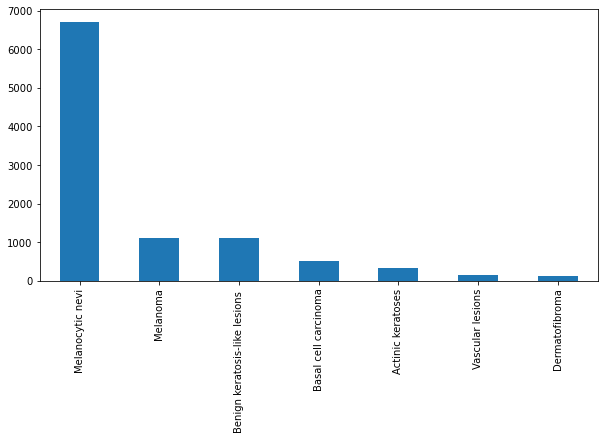

In [17]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

<AxesSubplot:>

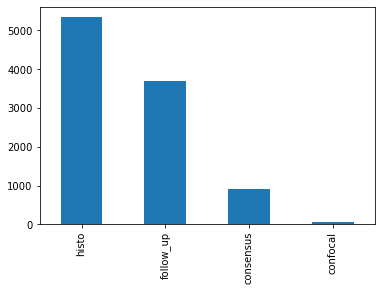

In [18]:
skin_df['dx_type'].value_counts().plot(kind='bar')

<AxesSubplot:>

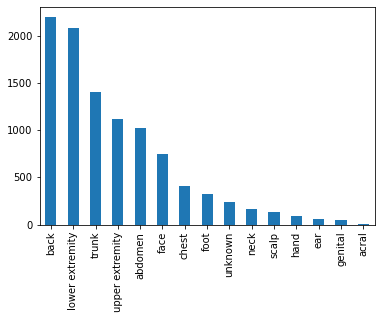

In [19]:
skin_df['localization'].value_counts().plot(kind='bar')

<AxesSubplot:>

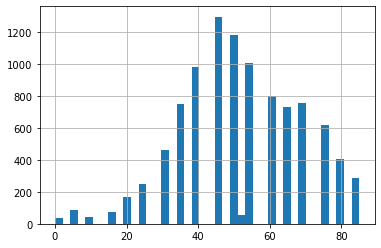

In [20]:
skin_df['age'].hist(bins=40)

<AxesSubplot:>

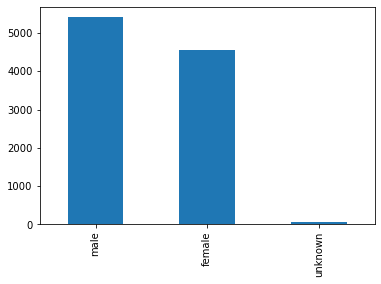

In [21]:
skin_df['sex'].value_counts().plot(kind='bar')

C:\Users\MDP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='age', ylabel='cell_type_idx'>

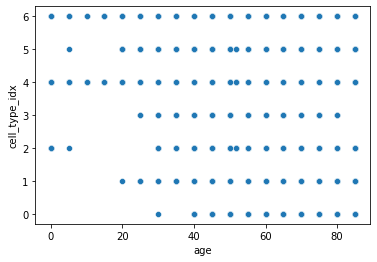

In [24]:
sns.scatterplot('age','cell_type_idx',data=skin_df)

C:\Users\MDP\anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\MDP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


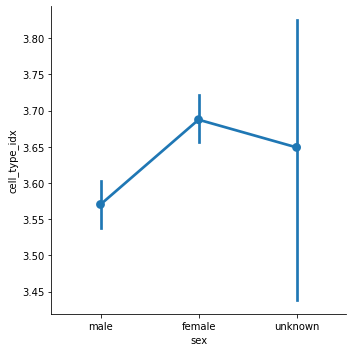

In [23]:
sns.factorplot('sex','cell_type_idx',data=skin_df)

In [8]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [42]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,C:\Users\MDP\Documents\Proje B\Inputs\HAM10000...,Benign keratosis-like lesions,2,"[[[190, 153, 194], [192, 154, 196], [191, 153,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,C:\Users\MDP\Documents\Proje B\Inputs\HAM10000...,Benign keratosis-like lesions,2,"[[[23, 13, 22], [24, 14, 24], [25, 14, 28], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,C:\Users\MDP\Documents\Proje B\Inputs\HAM10000...,Benign keratosis-like lesions,2,"[[[185, 127, 137], [189, 133, 147], [194, 136,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,C:\Users\MDP\Documents\Proje B\Inputs\HAM10000...,Benign keratosis-like lesions,2,"[[[24, 11, 17], [26, 13, 22], [38, 21, 32], [5..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,C:\Users\MDP\Documents\Proje B\Inputs\HAM10000...,Benign keratosis-like lesions,2,"[[[134, 90, 113], [147, 102, 125], [159, 115, ..."


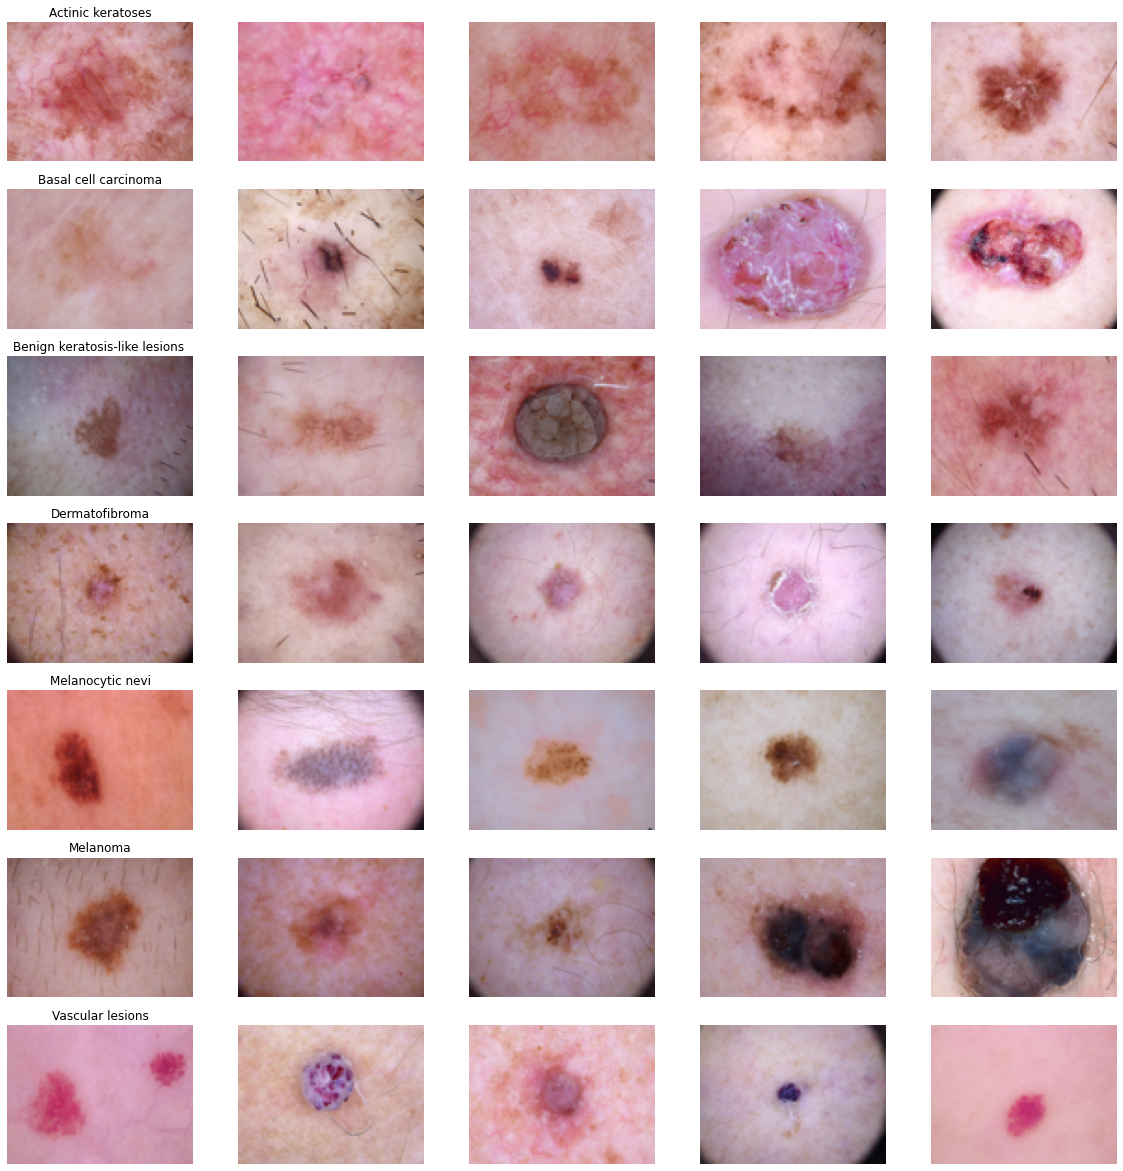

In [43]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [9]:
skin_df['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    10015
Name: image, dtype: int64

In [10]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

In [11]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=1234)

In [12]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [13]:
x_train

array([[[[-8.36112605e-02, -9.87720165e-01, -7.29403335e-01],
         [ 2.49434941e-03, -8.58561750e-01, -6.21771323e-01],
         [ 8.85999593e-02, -7.50929737e-01, -5.35665713e-01],
         ...,
         [-4.05584556e-02, -1.35366901e+00, -1.35366901e+00],
         [-1.69716870e-01, -1.50435382e+00, -1.54740663e+00],
         [-1.91243273e-01, -1.54740663e+00, -1.65503864e+00]],

        [[-1.90320531e-02, -9.23140957e-01, -6.86350530e-01],
         [ 6.70735568e-02, -7.72456140e-01, -5.57192115e-01],
         [ 1.53179167e-01, -6.64824127e-01, -4.92612908e-01],
         ...,
         [ 4.55471544e-02, -1.24603699e+00, -1.31061620e+00],
         [-8.36112605e-02, -1.37519541e+00, -1.46130102e+00],
         [-1.05137663e-01, -1.39672181e+00, -1.46130102e+00]],

        [[ 2.40207519e-02, -8.37035347e-01, -6.43297725e-01],
         [ 1.10126362e-01, -6.86350530e-01, -5.35665713e-01],
         [ 1.96231972e-01, -6.00244920e-01, -4.49560103e-01],
         ...,
         [ 2.40207519e-0

In [14]:
x_test

array([[[[ 1.1340068 , -0.89837225, -0.33622486],
         [ 1.09076469, -0.91999331, -0.44433012],
         [ 1.1340068 , -0.85513015, -0.40108802],
         ...,
         [ 0.98265942, -1.02809858, -0.48757223],
         [ 1.00428048, -0.98485647, -0.44433012],
         [ 1.04752259, -0.96323541, -0.44433012]],

        [[ 1.02590153, -1.02809858, -0.53081434],
         [ 1.00428048, -1.04971963, -0.57405645],
         [ 1.11238575, -0.8767512 , -0.42270907],
         ...,
         [ 1.02590153, -0.96323541, -0.48757223],
         [ 1.02590153, -0.94161436, -0.44433012],
         [ 0.98265942, -0.98485647, -0.55243539]],

        [[ 1.04752259, -0.94161436, -0.46595118],
         [ 1.06914364, -0.96323541, -0.48757223],
         [ 1.04752259, -1.00647752, -0.46595118],
         ...,
         [ 1.02590153, -0.94161436, -0.50919329],
         [ 1.02590153, -0.89837225, -0.48757223],
         [ 0.96103837, -1.00647752, -0.61729855]],

        ...,

        [[ 0.63672256, -1.11458279, -0

In [16]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

In [19]:
y_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [21]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [50]:
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [23]:
x_train

array([[[[ 1.10034088, -1.24603699, -0.75092974],
         [ 1.14339368, -1.15993138, -0.70787693],
         [ 1.14339368, -1.11687858, -0.68635053],
         ...,
         [ 1.46628972, -0.14819047,  0.08859996],
         [ 1.40171051, -0.23429608,  0.00249435],
         [ 1.35865771, -0.23429608, -0.04055846]],

        [[ 1.07881447, -1.22451059, -0.77245614],
         [ 1.03576167, -1.22451059, -0.81550894],
         [ 1.05728807, -1.18145779, -0.81550894],
         ...,
         [ 1.40171051, -0.34192809, -0.08361126],
         [ 1.35865771, -0.34192809, -0.10513766],
         [ 1.3156049 , -0.27734888, -0.04055846]],

        [[ 1.07881447, -1.18145779, -0.70787693],
         [ 1.03576167, -1.22451059, -0.77245614],
         [ 1.12186728, -1.11687858, -0.70787693],
         ...,
         [ 1.35865771, -0.49261291, -0.14819047],
         [ 1.3371313 , -0.32040169, -0.08361126],
         [ 1.2725521 , -0.36345449, -0.12666407]],

        ...,

        [[ 1.3156049 , -0.29887529, -0

In [24]:
x_test

array([[[[ 1.1340068 , -0.89837225, -0.33622486],
         [ 1.09076469, -0.91999331, -0.44433012],
         [ 1.1340068 , -0.85513015, -0.40108802],
         ...,
         [ 0.98265942, -1.02809858, -0.48757223],
         [ 1.00428048, -0.98485647, -0.44433012],
         [ 1.04752259, -0.96323541, -0.44433012]],

        [[ 1.02590153, -1.02809858, -0.53081434],
         [ 1.00428048, -1.04971963, -0.57405645],
         [ 1.11238575, -0.8767512 , -0.42270907],
         ...,
         [ 1.02590153, -0.96323541, -0.48757223],
         [ 1.02590153, -0.94161436, -0.44433012],
         [ 0.98265942, -0.98485647, -0.55243539]],

        [[ 1.04752259, -0.94161436, -0.46595118],
         [ 1.06914364, -0.96323541, -0.48757223],
         [ 1.04752259, -1.00647752, -0.46595118],
         ...,
         [ 1.02590153, -0.94161436, -0.50919329],
         [ 1.02590153, -0.89837225, -0.48757223],
         [ 0.96103837, -1.00647752, -0.61729855]],

        ...,

        [[ 0.63672256, -1.11458279, -0

## CNN

In [25]:
# CNN model 
# CNN mimarisi -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
input_shape = (75, 100, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 75, 100, 32)       896       
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 100, 32)       9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 37, 50, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 37, 50, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 50, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 37, 50, 64)        36928     
                                                        

In [27]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

C:\Users\MDP\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [28]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [36]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [30]:
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False, 
        featurewise_std_normalization=False, 
        samplewise_std_normalization=False, 
        zca_whitening=False, 
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=False, 
        vertical_flip=False)  

datagen.fit(x_train)

In [31]:
epochs = 20 
batch_size = 10
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size, 
                              callbacks=[learning_rate_reduction])

C:\Users\MDP\AppData\Local\Temp/ipykernel_8776/1491086325.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),


Epoch 1/50
721/721 [==============================] - 268s 367ms/step - loss: 1.0157 - accuracy: 0.6685 - val_loss: 0.9230 - val_accuracy: 0.6845 - lr: 0.0010
Epoch 2/50
721/721 [==============================] - 273s 379ms/step - loss: 0.9130 - accuracy: 0.6713 - val_loss: 0.8534 - val_accuracy: 0.6958 - lr: 0.0010
Epoch 3/50
721/721 [==============================] - 265s 368ms/step - loss: 0.8787 - accuracy: 0.6847 - val_loss: 0.8421 - val_accuracy: 0.7095 - lr: 0.0010
Epoch 4/50
721/721 [==============================] - 260s 361ms/step - loss: 0.8678 - accuracy: 0.6864 - val_loss: 0.8101 - val_accuracy: 0.7032 - lr: 0.0010
Epoch 5/50
721/721 [==============================] - 250s 347ms/step - loss: 0.8409 - accuracy: 0.6904 - val_loss: 0.7991 - val_accuracy: 0.7057 - lr: 0.0010
Epoch 6/50
721/721 [==============================] - 250s 346ms/step - loss: 0.8176 - accuracy: 0.6989 - val_loss: 0.7406 - val_accuracy: 0.7332 - lr: 0.0010
Epoch 7/50
721/721 [==========================

In [32]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model.h5")

26/26 [==============================] - 4s 151ms/step - loss: 0.6703 - accuracy: 0.7606
Validation: accuracy = 0.760598  ;  loss_v = 0.670310
Test: accuracy = 0.754868  ;  loss = 0.676390


KeyError: 'acc'

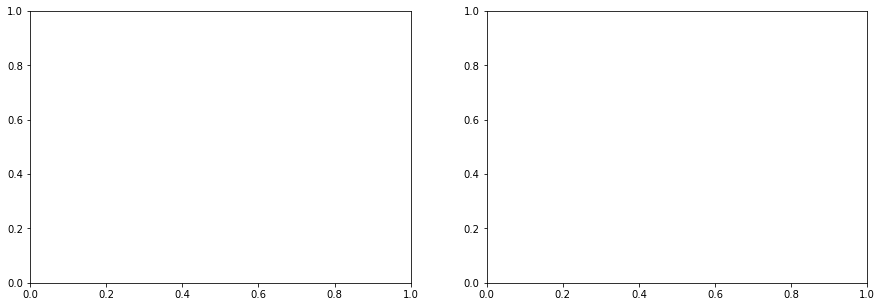

In [33]:
plot_model_history(history)

In [6]:
!pip install imblearn

  Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
  Using cached imbalanced_learn-0.9.0-py3-none-any.whl (199 kB)
  Using cached scikit_learn-1.1.0-cp39-cp39-win_amd64.whl (7.3 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.2
    Uninstalling scikit-learn-0.24.2:
      Successfully uninstalled scikit-learn-0.24.2


In [75]:
pip install -U imbalanced-learn

  Using cached imbalanced_learn-0.9.0-py3-none-any.whl (199 kB)
Note: you may need to restart the kernel to use updated packages.


In [87]:
conda install -c conda-forge imbalanced-learn

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\MDP\anaconda3

  added / updated specs:
    - imbalanced-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.12.0               |   py39hcbf5309_0         1.0 MB  conda-forge
    imbalanced-learn-0.7.0     |             py_1          97 KB  conda-forge
    python_abi-3.9             |           2_cp39           4 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         1.1 MB

The following NEW packages will be INSTALLED:

  imbalanced-learn   conda-forge/noarch::imbalanced-learn-0.7.0-py_1
  python_abi         conda-forge/win-64::python_abi-3.9-2_cp39

The following packages will be UPDATED:

  conda              pkgs/main::conda-4.11.0-py39haa95532_0 --> conda-forge::conda-4.12.0-py39hcbf5309_0




co



==> WARNING: A newer version of conda exists. <==
  current version: 4.11.0
  latest version: 4.12.0

Please update conda by running

    $ conda update -n base -c defaults conda




imbalanced-learn-0.7 | 97 KB     | ########## | 100% 
imbalanced-learn-0.7 | 97 KB     | ########## | 100% 

python_abi-3.9       | 4 KB      |            |   0% 
python_abi-3.9       | 4 KB      | ########## | 100% 
Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


In [91]:
pip install -v scikit-learn

Using pip 21.2.4 from C:\Users\MDP\anaconda3\lib\site-packages\pip (python 3.9)
Note: you may need to restart the kernel to use updated packages.


In [8]:
from imblearn.over_sampling import RandomOverSampler 

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler 
import numpy as np
from sklearn.model_selection import train_test_split
import os, cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout

In [40]:
path = os.path.join(r'C:\Users\MDP\Documents\Proje_B\Inputs')

images_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

In [3]:
import pandas as pd
data = pd.read_csv(r'C:\Users\MDP\Documents\Proje_B\Inputs\hmnist_28_28_RGB.csv')
data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


In [4]:
y = data['label']
x = data.drop(columns = ['label'])

In [6]:
tabular_data = pd.read_csv(r'C:\Users\MDP\Documents\Proje_B\Inputs\HAM10000_metadata.csv')
tabular_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [39]:
classes = {4: ('nv', 'Melanositik nevüs'), 
           6: ('mel', 'Melanom'), 
           2 :('bkl', 'Benign keratoz benzeri lezyonlar'), 
           1:('bcc' , 'Bazal hücreli karsinom'), 
           5: ('vasc', 'Piyojenik granülomlar ve kanama'), 
           0: ('akiec', 'Aktinik keratoz ve intraepitelyal karsinom'),  
           3: ('df', 'Dermatofibroma')}

Text(0.5, 1.0, 'Frequency Distribution of Classes')

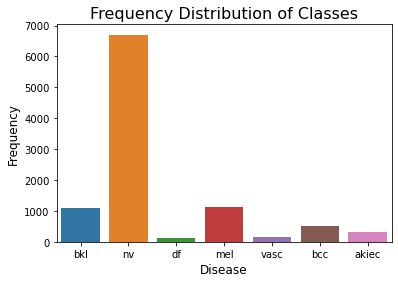

In [8]:
sns.countplot(x = 'dx', data = tabular_data)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Frequency Distribution of Classes', size=16)

Text(0.5, 1.0, 'Gender of Patient')

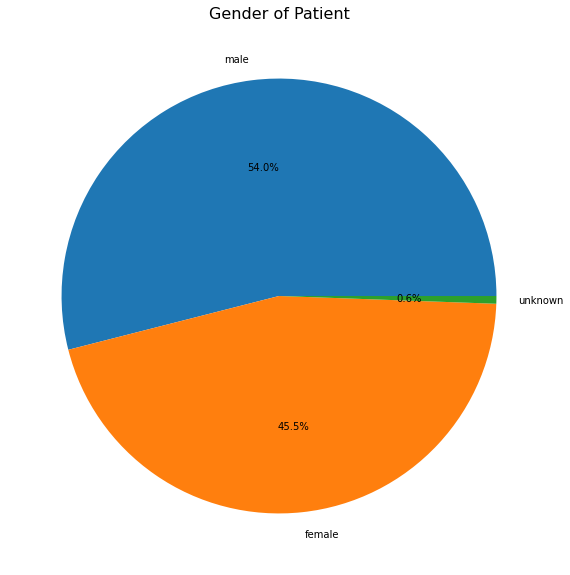

In [9]:
bar, ax = plt.subplots(figsize = (10,10))
plt.pie(tabular_data['sex'].value_counts(), labels = tabular_data['sex'].value_counts().index, autopct="%.1f%%")
plt.title('Gender of Patient', size=16)

Text(0.5, 1.0, 'Histogram of Age of Patients')

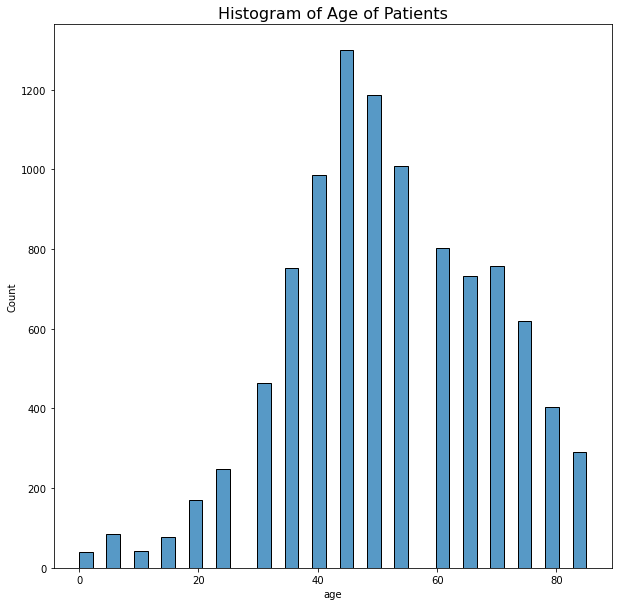

In [10]:
bar, ax = plt.subplots(figsize=(10,10))
sns.histplot(tabular_data['age'])
plt.title('Histogram of Age of Patients', size=16)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'back'),
  Text(1, 0, 'lower extremity'),
  Text(2, 0, 'trunk'),
  Text(3, 0, 'upper extremity'),
  Text(4, 0, 'abdomen'),
  Text(5, 0, 'face'),
  Text(6, 0, 'chest'),
  Text(7, 0, 'foot'),
  Text(8, 0, 'scalp'),
  Text(9, 0, 'neck'),
  Text(10, 0, 'unknown'),
  Text(11, 0, 'hand'),
  Text(12, 0, 'genital'),
  Text(13, 0, 'ear'),
  Text(14, 0, 'acral')])

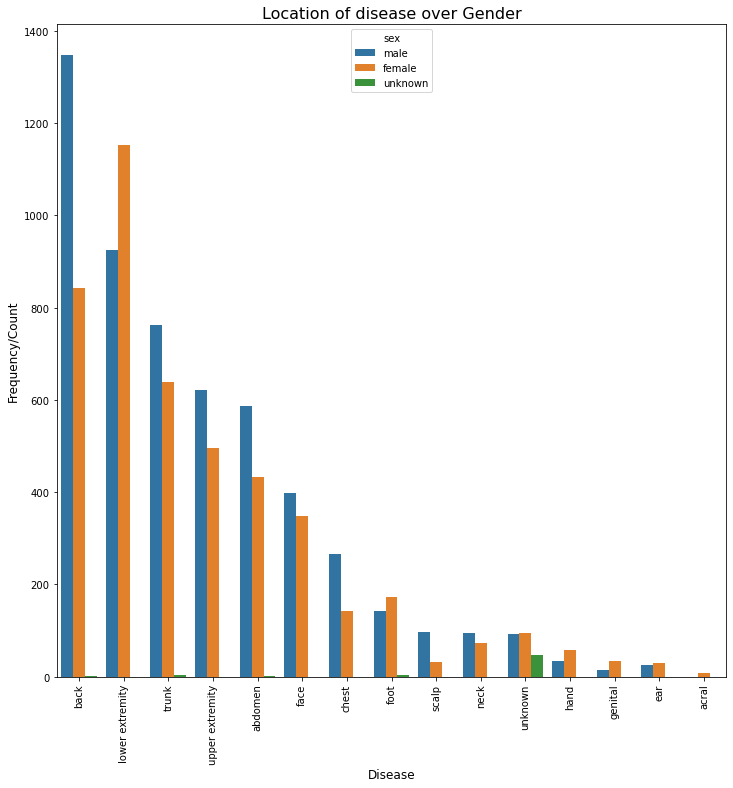

In [11]:
value = tabular_data[['localization', 'sex']].value_counts().to_frame()
value.reset_index(level=[1,0 ], inplace=True)
temp = value.rename(columns = {'localization':'location', 0: 'count'})

bar, ax = plt.subplots(figsize = (12, 12))
sns.barplot(x = 'location',  y='count', hue = 'sex', data = temp)
plt.title('Location of disease over Gender', size = 16)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency/Count', size=12)
plt.xticks(rotation = 90)

In [12]:
oversample = RandomOverSampler()
x,y  = oversample.fit_resample(x,y)

In [13]:
x = np.array(x).reshape(-1,28,28,3)
print('Shape of X :',x.shape)

Shape of X : (46935, 28, 28, 3)


In [14]:
x = (x-np.mean(x))/np.std(x)
X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=0.2, random_state=1)

In [15]:
X_train

array([[[[-0.0681461 , -1.34921153, -1.37338258],
         [-0.0681461 , -1.34921153, -1.34921153],
         [ 0.2460775 , -0.93830375, -0.81744852],
         ...,
         [ 0.41527482, -0.6482512 , -0.35819865],
         [ 0.46361691, -0.50322492, -0.23734342],
         [ 0.43944587, -0.47905388, -0.21317237]],

        [[-0.0681461 , -1.39755362, -1.34921153],
         [-0.0681461 , -1.39755362, -1.39755362],
         [ 0.05270913, -1.27669839, -1.2283563 ],
         ...,
         [ 0.46361691, -0.50322492, -0.3340276 ],
         [ 0.41527482, -0.62408015, -0.38236969],
         [ 0.36693273, -0.67242225, -0.45488283]],

        [[ 0.27024855, -0.81744852, -0.59990911],
         [ 0.22190645, -0.88996166, -0.69659329],
         [ 0.36693273, -0.67242225, -0.52739597],
         ...,
         [ 0.41527482, -0.6482512 , -0.47905388],
         [ 0.34276168, -0.79327748, -0.62408015],
         [ 0.19773541, -1.01081689, -0.88996166]],

        ...,

        [[ 0.29441959, -0.79327748, -0

In [16]:
X_test

array([[[[ 1.01955097,  0.27024855,  0.70532737],
         [ 1.01955097,  0.2460775 ,  0.60864319],
         [ 1.01955097,  0.10105122,  0.46361691],
         ...,
         [ 1.35794561,  0.511959  ,  0.92286679],
         [ 1.26126143,  0.46361691,  0.94703783],
         [ 1.18874829,  0.36693273,  0.87452469]],

        [[ 1.09206411,  0.36693273,  0.77784051],
         [ 1.1404062 ,  0.34276168,  0.72949842],
         [ 1.18874829,  0.29441959,  0.72949842],
         ...,
         [ 1.30960352,  0.43944587,  0.94703783],
         [ 1.11623515,  0.17356436,  0.75366946],
         [ 1.21291934,  0.39110378,  0.92286679]],

        [[ 1.16457725,  0.46361691,  0.92286679],
         [ 1.16457725,  0.39110378,  0.77784051],
         [ 1.26126143,  0.43944587,  0.8261826 ],
         ...,
         [ 1.28543247,  0.39110378,  0.92286679],
         [ 1.1404062 ,  0.17356436,  0.75366946],
         [ 1.26126143,  0.43944587,  0.99537992]],

        ...,

        [[ 1.33377457,  0.34276168,  0

In [17]:
Y_train

18033    1
38412    5
26590    2
6910     4
37704    5
        ..
43723    6
32511    3
5192     4
12172    0
33003    3
Name: label, Length: 37548, dtype: int64

In [18]:
model = Sequential()
model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(7, activation='softmax'))

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                    

In [20]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                                  monitor='val_acc', mode='max',
                                                 verbose=1)

In [21]:
model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = 'adam',
              metrics = ['accuracy'])

In [22]:
history = model.fit(X_train,
                    Y_train,
                    validation_split=0.2,
                    batch_size = 128,
                    epochs = 20,
                    callbacks=[callback])

Epoch 1/20
235/235 [==============================] - ETA: 0s - loss: 1.2111 - accuracy: 0.5305
Epoch 1: saving model to best_model.h5
235/235 [==============================] - 58s 240ms/step - loss: 1.2111 - accuracy: 0.5305 - val_loss: 0.8205 - val_accuracy: 0.6866
Epoch 2/20
235/235 [==============================] - ETA: 0s - loss: 0.6721 - accuracy: 0.7518
Epoch 2: saving model to best_model.h5
235/235 [==============================] - 58s 245ms/step - loss: 0.6721 - accuracy: 0.7518 - val_loss: 0.5300 - val_accuracy: 0.8071
Epoch 3/20
235/235 [==============================] - ETA: 0s - loss: 0.4473 - accuracy: 0.8356
Epoch 3: saving model to best_model.h5
235/235 [==============================] - 57s 243ms/step - loss: 0.4473 - accuracy: 0.8356 - val_loss: 0.4370 - val_accuracy: 0.8406
Epoch 4/20
235/235 [==============================] - ETA: 0s - loss: 0.3294 - accuracy: 0.8789
Epoch 4: saving model to best_model.h5
235/235 [==============================] - 54s 230ms/step 

In [25]:
model2 = Sequential()
model2.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
model2.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
model2.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.5))

model2.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model2.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model2.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
model.add(Dropout(0.5))
model2.add(Flatten())

model2.add(Dense(64, activation='relu'))
model2.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model2.add(Dense(7, activation='softmax'))

In [27]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 16)        448       
                                                                 
 conv2d_7 (Conv2D)           (None, 26, 26, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 13, 13, 32)        9248      
                                                                 
 conv2d_9 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                  

In [28]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                                  monitor='val_acc', mode='max',
                                                 verbose=1)

In [29]:
model2.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = 'adam',
              metrics = ['accuracy'])

In [30]:
history2 = model2.fit(X_train,
                    Y_train,
                    validation_split=0.2,
                    batch_size = 128,
                    epochs = 20,
                    callbacks=[callback])

Epoch 1/20
235/235 [==============================] - ETA: 0s - loss: 1.2507 - accuracy: 0.5175
Epoch 1: saving model to best_model.h5
235/235 [==============================] - 57s 237ms/step - loss: 1.2507 - accuracy: 0.5175 - val_loss: 0.8930 - val_accuracy: 0.6738
Epoch 2/20
235/235 [==============================] - ETA: 0s - loss: 0.7074 - accuracy: 0.7363
Epoch 2: saving model to best_model.h5
235/235 [==============================] - 56s 236ms/step - loss: 0.7074 - accuracy: 0.7363 - val_loss: 0.6054 - val_accuracy: 0.7694
Epoch 3/20
235/235 [==============================] - ETA: 0s - loss: 0.4962 - accuracy: 0.8169
Epoch 3: saving model to best_model.h5
235/235 [==============================] - 55s 236ms/step - loss: 0.4962 - accuracy: 0.8169 - val_loss: 0.4803 - val_accuracy: 0.8285
Epoch 4/20
235/235 [==============================] - ETA: 0s - loss: 0.3611 - accuracy: 0.8711
Epoch 4: saving model to best_model.h5
235/235 [==============================] - 56s 239ms/step 

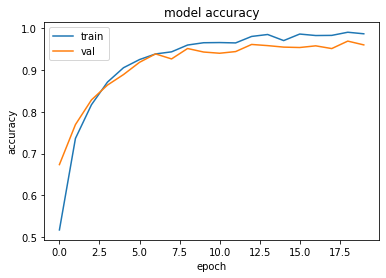

In [31]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

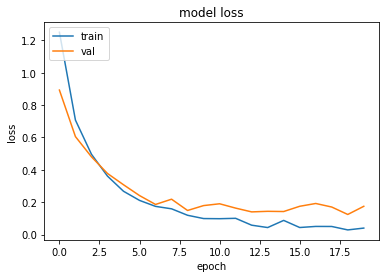

In [32]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [37]:
model2.load_weights('best_model.h5')

In [38]:
loss, acc = model2.evaluate(X_test, Y_test, verbose=2)


294/294 - 5s - loss: 0.1902 - accuracy: 0.9592 - 5s/epoch - 16ms/step


In [43]:
pip install google-colab

  Using cached google_colab-1.0.0-py2.py3-none-any.whl
  Using cached google_auth-1.4.2-py2.py3-none-any.whl (64 kB)
  Using cached notebook-5.2.2-py2.py3-none-any.whl (8.0 MB)
  Using cached pandas-0.24.2.tar.gz (11.8 MB)
Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: nbclient<0.6.0,>=0.5.0 in c:\users\mdp\anaconda3\lib\site-packages (from nbconvert->notebook~=5.2.0->google-colab) (0.5.3)



  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\MDP\anaconda3\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\MDP\\AppData\\Local\\Temp\\pip-install-2vwrw40u\\pandas_c82540844791482a99f5d64fd64fe237\\setup.py'"'"'; __file__='"'"'C:\\Users\\MDP\\AppData\\Local\\Temp\\pip-install-2vwrw40u\\pandas_c82540844791482a99f5d64fd64fe237\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\MDP\AppData\Local\Temp\pip-wheel-z8rtvwd4'
       cwd: C:\Users\MDP\AppData\Local\Temp\pip-install-2vwrw40u\pandas_c82540844791482a99f5d64fd64fe237\
  Complete output (841 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-3.9
  creating build\

  Running setup.py clean for pandas
Failed to build pandas
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.4
    Uninstalling pandas-1.3.4:
      Successfully uninstalled pandas-1.3.4
    Running setup.py install for pandas: started
    Running setup.py install for pandas: still running...
    Running setup.py install for pandas: still running...
    Running setup.py install for pandas: finished with status 'error'
  Rolling back uninstall of pandas
  Moving to c:\users\mdp\anaconda3\lib\site-packages\pandas-1.3.4.dist-info\
   from C:\Users\MDP\anaconda3\Lib\site-packages\~andas-1.3.4.dist-info
  Moving to c:\users\mdp\anaconda3\lib\site-packages\pandas\
   from C:\Users\MDP\anaconda3\Lib\site-packages\~andas



  copying pandas\tests\test_take.py -> build\lib.win-amd64-3.9\pandas\tests
  copying pandas\tests\test_window.py -> build\lib.win-amd64-3.9\pandas\tests
  copying pandas\tests\__init__.py -> build\lib.win-amd64-3.9\pandas\tests
  creating build\lib.win-amd64-3.9\pandas\tseries
  copying pandas\tseries\api.py -> build\lib.win-amd64-3.9\pandas\tseries
  copying pandas\tseries\converter.py -> build\lib.win-amd64-3.9\pandas\tseries
  copying pandas\tseries\frequencies.py -> build\lib.win-amd64-3.9\pandas\tseries
  copying pandas\tseries\holiday.py -> build\lib.win-amd64-3.9\pandas\tseries
  copying pandas\tseries\offsets.py -> build\lib.win-amd64-3.9\pandas\tseries
  copying pandas\tseries\plotting.py -> build\lib.win-amd64-3.9\pandas\tseries
  copying pandas\tseries\__init__.py -> build\lib.win-amd64-3.9\pandas\tseries
  creating build\lib.win-amd64-3.9\pandas\util
  copying pandas\util\testing.py -> build\lib.win-amd64-3.9\pandas\util
  copying pandas\util\_decorators.py -> build\lib.w

In [2]:
pip install opencv-python

  Using cached opencv_python-4.5.5.64-cp36-abi3-win_amd64.whl (35.4 MB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
import cv2